In [1]:
#pip install vaderSentiment

In [2]:
from PyPDF2 import PdfReader
import numpy as np
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tabulate import tabulate

In [3]:
# what we need to start 
company_list = ['10-K_BAC_reporting2020.pdf', '10-K_BAC_reporting2021.pdf', '10-K_BAC_reporting2022.pdf',\
                'General_electric_2020.pdf','General_electric_reporting_2021.pdf','General_electric_reporting_2022.pdf', '10-K_Tesla_reporting2020.pdf', '10-K_Tesla_reporting2021.pdf',\
                '10-K_Tesla_reporting2022.pdf','10-KHershey2020.pdf','10-KHershey2021.pdf','10-KHershey2022.pdf']


social = pd.read_excel('social.xlsx')
environment = pd.read_excel('environment.xlsx')
economy = pd.read_excel('economy.xlsx')
social_words = social['social words'].tolist()
environment_words = environment['environment words'].tolist()
economy_words = economy['economy words'].tolist()
words_list = social_words + environment_words + economy_words

stop_words = set(stopwords.words("english"))

cleaner = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

# LM_dictionary = pd.read_excel('LM_MasterDictionary.xlsx', dtype={'Word': str})
# neg = LM_dictionary[LM_dictionary['Negative']>0]['Word'].tolist()
# pos = LM_dictionary[LM_dictionary['Positive']>0]['Word'].tolist()

analyzer = SentimentIntensityAnalyzer()

In [4]:
# functions
def extract(pdf_file:str):
    file_read = PdfReader(pdf_file)
    pdf_text=""
    for page in file_read.pages:
        content = page.extract_text()
        pdf_text += content
    return pdf_text 

def cleanhtml(raw_html):
  cleantext = re.sub(cleaner, '', raw_html)
  return cleantext

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespace(text):
    return  " ".join(text.split())

def esg_percentage(text_file,list_of_words):
    count = 0
    text_split = text_file.split()
    n = len(text_split)
    for i in range(0,n):
        for word in list_of_words:
            if text_split[i]==word.lower(): 
                count += 1 
            elif i<n-1 and text_split[i]+" "+text_split[i+1]==word.lower(): 
                count += 1 
            elif i<n-2 and text_split[i]+" "+text_split[i+1]+" "+text_split[i+2]==word.lower():
                count += 1 
            elif i<n-3 and text_split[i]+" "+text_split[i+1]+" "+text_split[i+2]+" "+text_split[i+3]==word.lower():
                count += 1
    percentage_words = count/n
    return percentage_words

def clean_list(list,list_of_words):
    new_list = []
    accepted = 0 
    total_number_phrases = len(list)
    for phrase in list:
        phrase = remove_punctuation(phrase) # remove punctuation
        phrase = re.sub(r'[^\w]', ' ', phrase) # remove all character that are different from words
        words_list = word_tokenize(phrase) # create a list of words from the string phrase
        filtered_words_list = [word for word in words_list if word not in stop_words] # remove stopwords
        count = 0
        n = len(filtered_words_list)
        for i in range(0,n):
            for word in list_of_words:
                if filtered_words_list[i]==word.lower(): 
                    count += 1 
                elif i<n-1 and filtered_words_list[i]+" "+filtered_words_list[i+1]==word.lower(): 
                    count += 1 
                elif i<n-2 and filtered_words_list[i]+" "+filtered_words_list[i+1]+" "+filtered_words_list[i+2]==word.lower():
                    count += 1 
                elif i<n-3 and filtered_words_list[i]+" "+filtered_words_list[i+1]+" "+filtered_words_list[i+2]+" "+filtered_words_list[i+3]==word.lower():
                    count += 1
        if count != 0: 
            accepted += 1
            phrase = ' '.join(filtered_words_list) # create again the string 
            new_list = new_list + [phrase]
    return new_list, accepted/total_number_phrases

def count_neg_pos(text):
    count_neg = 0
    count_pos = 0 
    for word in word_tokenize(text):
        count_neg += 1 if word.upper() in neg else 0
        count_pos += 1 if word.upper() in pos else 0
    return (count_pos-count_neg)/(count_pos+count_neg)

def vader_phrase(list):
    n = len(list)
    count_pos = 0
    count_neg = 0 
    count_neut = 0 
    pos = 0 
    neg = 0 
    neut = 0
    compound = 0 
    for sentence in list:
        score = analyzer.polarity_scores(sentence)
        compound = score['compound'] + compound
        if score['compound']>= 0.05:
            count_pos += 1
            pos = pos + score['compound']
        elif score['compound']<= -0.05:
            count_neg += 1
            neg = neg + score['compound']
        else: 
            count_neut += 1
            neut = neut + score['compound']
    if n>0 : 
        x = count_pos/n
        y = count_neg/n
        z = count_neut/n
    else:
        x = 0
        y = 0 
        z = 0
    if count_pos>0: 
        a = pos/count_pos
    else: 
        a = 0 
    if count_neg>0:
        b = neg/count_neg
    else: 
        b = 0
    if count_neut>0:
        c = neut/count_neut
    else: 
        c = 0 
    array = np.array([compound/n,x, y, z, a, b, c])
    return array 

def vader_doc(text): 
    score = analyzer.polarity_scores(text)
    if score['compound']>= 0.05:
        result = 'positive'
    elif score['compound']<= -0.05:
        result = 'negative'
    else: 
        result = 'neutral'
    array = np.array([result, score['compound']])
    return array

In [5]:
list_companies = ['BAC_2020', 'BAC_2021', 'BAC_2022', 'GE_2020', 'GE_2021', 'GE_2022','Tesla_2020', 'Tesla_2021','Tesla_2022','Hershey_2020','Hershey_2021','Hershey_2022']

df_phrases = pd.DataFrame(columns=['average_compound','perc_pos','perc_neg','perc_neut', 'mean_pos', 'mean_neg', 'mean_neut', 'perc_esg_phrases'], index=list_companies)
df_document = pd.DataFrame(columns=['sentiment','score'], index=list_companies)
count = 0
for i in company_list: 
    x = extract(i)
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    series_phrases = vader_phrase(x)
    df_phrases.loc[list_companies[count]] = pd.Series({'average_compound': series_phrases[0],'perc_pos': series_phrases[1], 'perc_neg': series_phrases[2], 'perc_neut': series_phrases[3], 'mean_pos': series_phrases[4], 'mean_neg': series_phrases[5], 'mean_neut': series_phrases[6], 'perc_esg_phrases': acceptance_rate})
    x = ' '.join(x)
    series_document = vader_doc(x)
    df_document.loc[list_companies[count]] =  pd.Series({'sentiment': series_document[0], 'score': series_document[1]})
    count += 1
    # polarity = [count_neg_pos(x)] + polarity

In [6]:
df_phrases

,average_compound,perc_pos,perc_neg,perc_neut,mean_pos,mean_neg,mean_neut,perc_esg_phrases
BAC_2020,0.176725,0.511757,0.206086,0.282158,0.512859,-0.416703,0.000506,0.097597
BAC_2021,0.187265,0.534435,0.19697,0.268595,0.511641,-0.438042,0.000397,0.100735
BAC_2022,0.179079,0.514894,0.201418,0.283688,0.520348,-0.441099,0.0,0.099576
GE_2020,0.257724,0.617591,0.16826,0.214149,0.525684,-0.396331,-0.001152,0.140856
GE_2021,0.27388,0.639155,0.153551,0.207294,0.525749,-0.401562,-0.002389,0.154142
GE_2022,0.253466,0.60396,0.160396,0.235644,0.537342,-0.440842,-0.001518,0.163008
Tesla_2020,0.317534,0.671642,0.139303,0.189055,0.554938,-0.397534,0.001018,0.116488
Tesla_2021,0.322764,0.675532,0.138298,0.18617,0.565821,-0.430983,0.000737,0.12336
Tesla_2022,0.292674,0.638554,0.153614,0.207831,0.558687,-0.417137,0.0,0.120159
Hershey_2020,0.376932,0.707692,0.094872,0.197436,0.589932,-0.429197,0.000816,0.132653


In [7]:
['BAC_2020', 'BAC_2021', 'BAC_2022', 'GE_2020', 'GE_2021', 'GE_2022','Tesla_2020', 'Tesla_2021','Tesla_2022','Hershey_2020','Hershey_2021','Hershey_2022']


# general 
mean_scores = df_phrases['average_compound'].mean()
std_scores = df_phrases['average_compound'].std()
# per year 
mean_2020 = df_phrases.loc[['BAC_2020', 'GE_2020','Tesla_2020','Hershey_2020']]['average_compound'].mean()
std_2020 =  df_phrases.loc[['BAC_2020', 'GE_2020','Tesla_2020','Hershey_2020']]['average_compound'].std()
mean_2021 = df_phrases.loc[['BAC_2021', 'GE_2021','Tesla_2021','Hershey_2021']]['average_compound'].mean()
std_2021 = df_phrases.loc[['BAC_2021', 'GE_2021','Tesla_2021','Hershey_2021']]['average_compound'].std()
mean_2022 = df_phrases.loc[['BAC_2022', 'GE_2022','Tesla_2022','Hershey_2022']]['average_compound'].mean()
std_2022 = df_phrases.loc[['BAC_2022', 'GE_2022','Tesla_2022','Hershey_2022']]['average_compound'].std()


In [8]:
print(tabulate([['General_mean', mean_scores],['General_std',std_scores],
                ['Mean_2020',mean_2020],['Std_2020',std_2020], 
                ['Mean_2021',mean_2021],['Std_2021',std_2021],
                ['Mean_2022',mean_2022],['Std_2022',std_2022]],
                headers=['Statistics', 'Values'],tablefmt = 'fancy_grid',stralign = 'center', numalign= 'center',floatfmt=".2f"))

╒══════════════╤══════════╕
│  Statistics  │  Values  │
╞══════════════╪══════════╡
│ General_mean │   0.28   │
├──────────────┼──────────┤
│ General_std  │   0.07   │
├──────────────┼──────────┤
│  Mean_2020   │   0.28   │
├──────────────┼──────────┤
│   Std_2020   │   0.09   │
├──────────────┼──────────┤
│  Mean_2021   │   0.29   │
├──────────────┼──────────┤
│   Std_2021   │   0.07   │
├──────────────┼──────────┤
│  Mean_2022   │   0.28   │
├──────────────┼──────────┤
│   Std_2022   │   0.08   │
╘══════════════╧══════════╛


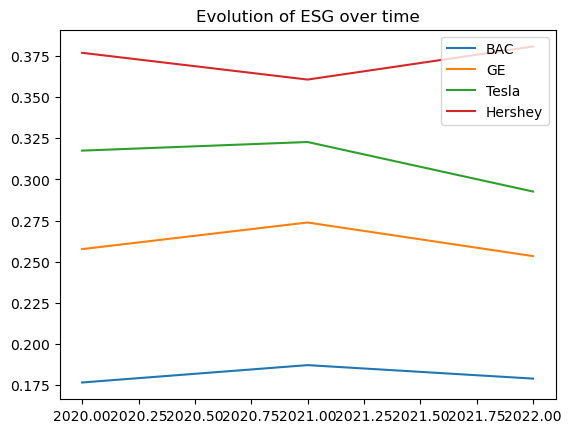

In [9]:
import matplotlib.pyplot as plt

data_BAC = {'years': [2020,2021,2022],
        'average_compound': [df_phrases['average_compound'][0], df_phrases['average_compound'][1], df_phrases['average_compound'][2]]
       }
data_BAC = pd.DataFrame(data_BAC)
data_GE = {'years': [2020,2021,2022],
        'average_compound': [df_phrases['average_compound'][3], df_phrases['average_compound'][4], df_phrases['average_compound'][5]]
       }
data_GE = pd.DataFrame(data_GE)
data_Tesla = {'years': [2020,2021,2022],
        'average_compound': [df_phrases['average_compound'][6], df_phrases['average_compound'][7], df_phrases['average_compound'][8]]
       }
data_Tesla = pd.DataFrame(data_Tesla)
data_Hershey = {'years': [2020,2021,2022],
        'average_compound': [df_phrases['average_compound'][9], df_phrases['average_compound'][10], df_phrases['average_compound'][11]]
       }
data_hershey = pd.DataFrame(data_Tesla)

plt.plot(data_BAC['years'], data_BAC['average_compound'], label = 'BAC')
plt.plot(data_GE['years'], data_GE['average_compound'], label = 'GE')
plt.plot(data_Tesla['years'], data_Tesla['average_compound'], label = 'Tesla')
plt.plot(data_Hershey['years'], data_Hershey['average_compound'], label = 'Hershey')

#data_BAC.plot(x ='years', y='perc_esg_phrases', kind='line', label = 'BAC')
#data_Beyondmeat.plot(x ='years', y='perc_esg_phrases', kind='line', label = 'Beyondmeat')
#data_Petrogas.plot(x ='years', y='perc_esg_phrases', kind='line', label = 'Petrogas')
#data_Tesla.plot(x ='years', y='perc_esg_phrases', kind='line', label = 'Tesla')
plt.title('Evolution of ESG over time')
plt.legend()
plt.show()
#plt.savefig('Evolution_of_ESG_over_time.pn

In [10]:
ESG_scores_MSCI = pd.read_csv('msci scores - Msci_scores(1).csv', delimiter=',')

#sigmoid function
def sigmoid(x) :
    y = 1/(1 + np.exp(-x))
    return y

#for i in range (len(df_phrases['average_compound'])) :
    #df_phrases['average_compound'][i] = sigmoid(df_phrases['average_compound'][i])
    
print(df_phrases['average_compound'])

BAC_2020        0.176725
BAC_2021        0.187265
BAC_2022        0.179079
GE_2020         0.257724
GE_2021          0.27388
GE_2022         0.253466
Tesla_2020      0.317534
Tesla_2021      0.322764
Tesla_2022      0.292674
Hershey_2020    0.376932
Hershey_2021    0.360682
Hershey_2022    0.380777
Name: average_compound, dtype: object


In [11]:
import statsmodels.api as sm

#BAC

X = [df_phrases['average_compound'][0], df_phrases['average_compound'][1], df_phrases['average_compound'][2]]
y = [ESG_scores_MSCI['2019'][8],ESG_scores_MSCI['2020'][8],ESG_scores_MSCI['2021'][8]]

regsummary= sm.OLS(y,X).fit()
regsummary.summary()

with open('summary_BAC_VADER.csv', 'w') as fh:
    fh.write(regsummary.summary().as_csv())


/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [12]:
import statsmodels.api as sm

#GE

X = [df_phrases['average_compound'][3], df_phrases['average_compound'][4], df_phrases['average_compound'][5]]
y = [ESG_scores_MSCI['2019'][14],ESG_scores_MSCI['2020'][14],ESG_scores_MSCI['2021'][14]]

regsummary= sm.OLS(y,X).fit()
regsummary.summary()

with open('summary_GE_VADER.csv', 'w') as fh:
    fh.write(regsummary.summary().as_csv())

/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [13]:
import statsmodels.api as sm

#Tesla

X = [df_phrases['average_compound'][6], df_phrases['average_compound'][7], df_phrases['average_compound'][8]]
y = [ESG_scores_MSCI['2019'][2],ESG_scores_MSCI['2020'][2],ESG_scores_MSCI['2021'][2]]

regsummary= sm.OLS(y,X).fit()
regsummary.summary()

with open('summary_Tesla_VADER.csv', 'w') as fh:
    fh.write(regsummary.summary().as_csv())

/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [14]:
import statsmodels.api as sm

#Hershey

X = [df_phrases['average_compound'][9], df_phrases['average_compound'][10], df_phrases['average_compound'][11]]
y = [ESG_scores_MSCI['2019'][6],ESG_scores_MSCI['2020'][6],ESG_scores_MSCI['2021'][6]]

regsummary= sm.OLS(y,X).fit()
regsummary.summary()

with open('summary_Hershey_VADER.csv', 'w') as fh:
    fh.write(regsummary.summary().as_csv())

/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [15]:
import statsmodels.formula.api as sm
import statsmodels.api as sm

#data_new = df_phrases
#data_new['ESG_scores'] = [28,26,27,46,43,41,31,31,29,25,26,27]
#result = sm.ols(formula="ESG_scores ~ average_compound", data=data_new).fit()
#print(result.summary())
X = [df_phrases['average_compound'][0], df_phrases['average_compound'][1],\
     df_phrases['average_compound'][2],df_phrases['average_compound'][3],\
     df_phrases['average_compound'][4],df_phrases['average_compound'][5],
     df_phrases['average_compound'][6],df_phrases['average_compound'][7],
     df_phrases['average_compound'][8],df_phrases['average_compound'][9],
     df_phrases['average_compound'][10],df_phrases['average_compound'][11]]

y = [ESG_scores_MSCI['2019'][8],ESG_scores_MSCI['2020'][8],ESG_scores_MSCI['2021'][8],\
    ESG_scores_MSCI['2019'][14],ESG_scores_MSCI['2020'][14],ESG_scores_MSCI['2021'][14],
    ESG_scores_MSCI['2019'][2],ESG_scores_MSCI['2020'][2],ESG_scores_MSCI['2021'][2],
    ESG_scores_MSCI['2019'][6],ESG_scores_MSCI['2020'][6],ESG_scores_MSCI['2021'][6]]


regsummary= sm.OLS(y,X).fit()
regsummary.summary()



/Users/mechtimajda/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              131.3
Date:                Tue, 06 Jun 2023   Prob (F-statistic):                    1.87e-07
Time:                        17:50:33   Log-Likelihood:                         -20.301
No. Observations:                  12   AIC:                                      42.60
Df Residuals:                      11   BIC:                                      43.09
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            15.6308      1.364     11.460      0.000      12.629      18.633
==============================================================================
Omnibus:                        1.808   Durbin-Watson:                   0.589
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                0.953
Skew:                          -0.292   Prob(JB):                        0.621
Kurtosis:                       1.749   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""